# Compute the daily average for each region

This notebook computes the daily average for each region in the datasets.

The dataset comes from the script `./transform_arpeg_data.py` and is stored in the `./data/` directory.

The dataset have also been uploaded to [kaggle](https://www.kaggle.com/datasets/antoinetavant/weather-forecast-france-regions). We will use this to get the datasets.
Add the needed API key to download the datasets from kaggle. 

In [42]:
%pip install -q kaggle

Note: you may need to restart the kernel to use updated packages.


In [ ]:
data_root = "../../data/silver/"

In [3]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    "antoinetavant/weather-forecast-france-regions", path=data_root, unzip=True
)

In [11]:
import dask.dataframe as dd
import pandas as pd

file_sun = data_root + "group_mean_sun.csv"
file_wind = data_root + "group_means_wind.csv"

In [26]:
sun_dd = dd.read_csv(file_sun, parse_dates=["time", "valid_time"])
sun_dd["step"] = sun_dd["valid_time"] - sun_dd["time"]
sun_dd.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   Unnamed: 0  5 non-null      int64          
 1   time        5 non-null      datetime64[ns] 
 2   step        5 non-null      timedelta64[ns]
 3   region      5 non-null      object         
 4   valid_time  5 non-null      datetime64[ns] 
 5   ssrd        5 non-null      float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 368.0+ bytes


In [27]:
sun_dd_j0 = sun_dd[sun_dd["step"] < pd.Timedelta("1 days")]
sun_dd_j0

,Unnamed: 0,time,step,region,valid_time,ssrd
npartitions=1,,,,,,
,int64,datetime64[ns],timedelta64[ns],string,datetime64[ns],float64
,...,...,...,...,...,...


In [31]:
mean_daily_sun = sun_dd_j0.groupby(["time", "region"])["ssrd"].mean().compute()
mean_daily_sun

time        region                    
2022-02-01  Auvergne-Rhône-Alpes          261520.851689
            Bourgogne-Franche-Comté        90775.394750
            Bretagne                      163552.580967
            Centre-Val de Loire            34723.093875
            Corse                         456686.957700
                                              ...      
2024-04-07  Nouvelle-Aquitaine            365032.085625
            Occitanie                     540125.876458
            Pays de la Loire              233334.018625
            Provence-Alpes-Côte d'Azur    692582.625167
            Île-de-France                 197554.021667
Name: ssrd, Length: 10023, dtype: float64

In [40]:
mean_daily_sun.unstack(level=1).to_csv(data_root + "mean_daily_sun_j0.csv")

## Processing Wind

In [41]:
wind_dd = dd.read_csv(file_wind, parse_dates=["time", "valid_time"])
wind_dd["step"] = wind_dd["valid_time"] - wind_dd["time"]
wind_dd_j0 = wind_dd[wind_dd["step"] < pd.Timedelta("1 days")]
mean_daily_wind = wind_dd_j0.groupby(["time", "region"])["si10"].mean().compute()
mean_daily_wind.unstack(level=1).to_csv(data_root + "mean_daily_wind_j0.csv")

# Visualize the data

<Axes: title={'center': 'Mean daily wind speed in France regions'}, xlabel='time'>

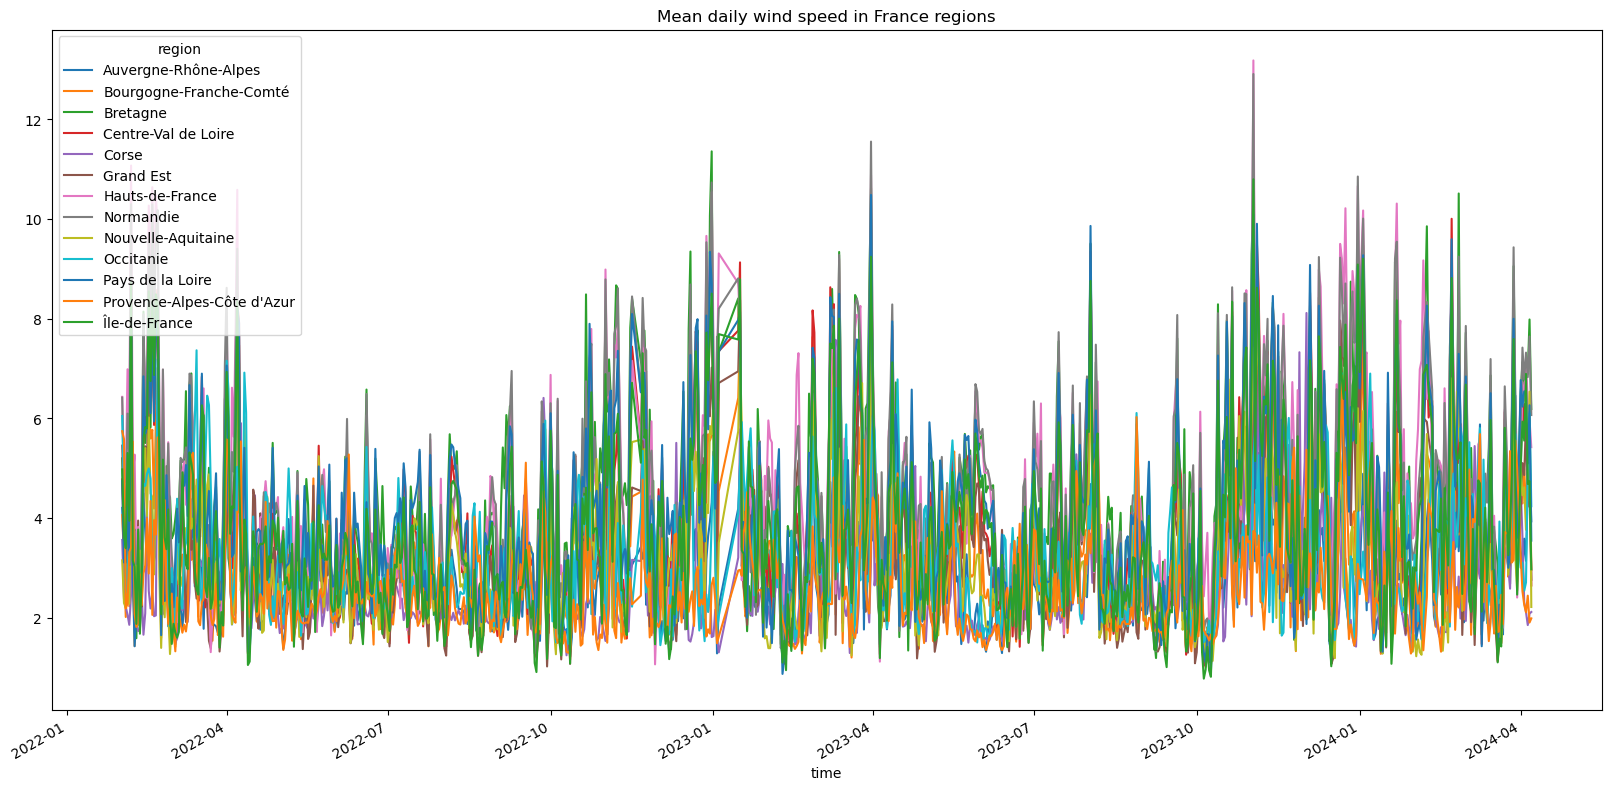

In [38]:
mean_daily_wind.unstack(level=1).plot(
    figsize=(20, 10), title="Mean daily wind speed in France regions"
)

<Axes: title={'center': 'Mean daily sun radiation in France regions'}, xlabel='time'>

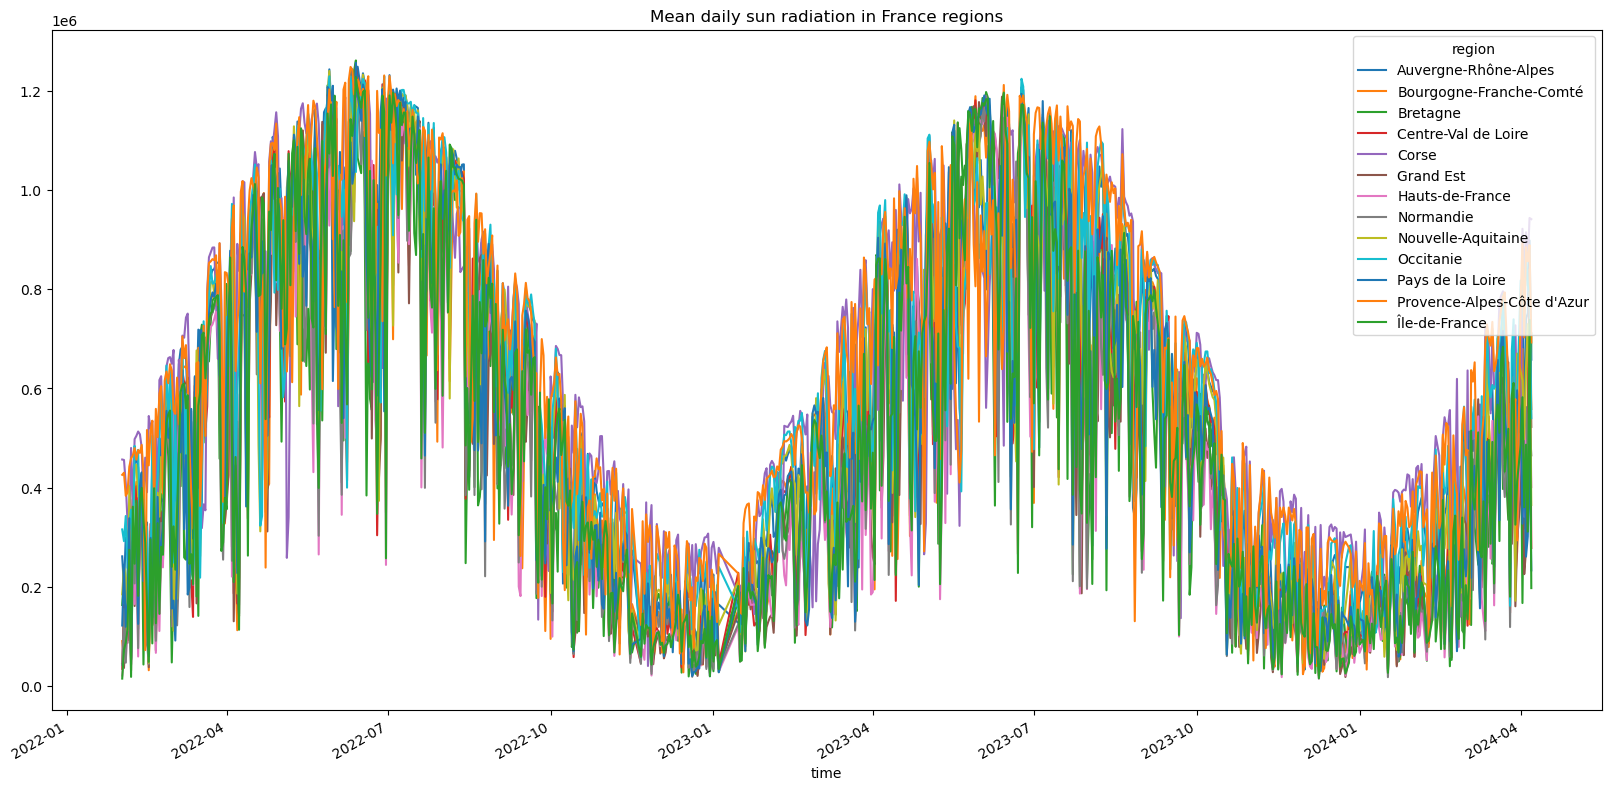

In [39]:
mean_daily_sun.unstack(level=1).plot(
    figsize=(20, 10), title="Mean daily sun radiation in France regions"
)